In [2]:
import pandas as pd
from gensim.models import Word2Vec
import numpy as np
import ast

In [3]:
df = pd.read_csv("/Users/barnabasepres/University/TDK/trump_speech_analysis/word2vec_vectors.csv")
df['Vector2'] = df['Vector'].apply(ast.literal_eval)
def getVectorList(vector):
    vector_list = list()
    for i in vector[0]:
        vector_list.append(i)

    return vector_list

df['Vector3'] = df['Vector2'].apply(getVectorList)

In [4]:
#merge data for modelling with vectors
df_for_model = pd.read_excel("data_for_rfmodel.xlsx")
df_for_model.drop(columns=["tfidf1", "tfidf2", "tfidf3", "tfidf4", "tfidf5"])

,doc_id,date,month,day,day_of_the_week,state,nth_speech_in_state,negative,positive,neg_positive,neg_negative,CTTR,scale,popularity,popularity_tminus1,popularity_tplus1,frequency
0,text1,2024-06-06,6,6,4,AZ,1,0.438415,0.546081,0.015504,0.000000,11.842610,-0.204342,0.475,0.475,0.475,0
1,text2,2024-06-09,6,9,7,NV,1,0.519054,0.461235,0.014455,0.005256,10.966973,-0.229203,0.475,0.475,0.475,1
2,text3,2024-06-15,6,15,6,MI,1,0.430980,0.554268,0.013699,0.001054,12.737853,-0.162079,0.475,0.475,0.475,1
3,text4,2024-06-18,6,18,2,WI,1,0.457612,0.531142,0.009516,0.001730,12.352709,-0.152792,0.475,0.475,0.475,1
4,text5,2024-06-22,6,22,6,PA,1,0.451859,0.537655,0.007626,0.002860,13.918023,-0.170511,0.475,0.475,0.475,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68,text69,2024-11-03,11,3,7,GA,6,0.432358,0.555759,0.011883,0.000000,12.104690,-0.157758,0.478,0.478,0.470,13
69,text70,2024-11-04,11,4,1,NC,13,0.384886,0.605448,0.008787,0.000879,11.735346,-0.137013,0.470,0.478,0.470,15
70,text71,2024-11-04,11,4,1,PA,15,0.380865,0.608096,0.011040,0.000000,11.788456,-0.157422,0.470,0.470,0.470,15
71,text72,2024-11-04,11,4,1,PA,16,0.397037,0.595556,0.005926,0.001481,12.110096,-0.188384,0.470,0.470,0.470,15


In [5]:
df['textid2'] = 'text' + df['textid'].astype(str)
df.head(1)

num_vectors = 5
num_rows = df.shape[0] // num_vectors  # Ensure it is divisible

# Create an empty DataFrame with proper structure
vector_form_models = pd.DataFrame(columns=[f'Vector{i+1}' for i in range(num_vectors)])

# Reshape df column 8 into 5 columns
vector_for_models = pd.DataFrame(df.iloc[:num_rows * num_vectors, 8].values.reshape(num_rows, num_vectors),
                            columns=[f'Vector{i+1}' for i in range(num_vectors)])

vector_for_models.head(1)

,Vector1,Vector2,Vector3,Vector4,Vector5
0,"[0.049790073186159134, -0.0983961820602417, -0...","[0.875714898109436, 0.16472674906253815, -0.23...","[-0.08419185131788254, 0.0366925410926342, 0.5...","[0.04988595470786095, -0.06017261743545532, -0...","[0.5563291311264038, 0.3300783336162567, 0.226..."


In [6]:
vector_for_models['doc_id'] = np.arange(1, 74) 
vector_for_models['doc_id'] = 'text' + vector_for_models['doc_id'].astype(str)

df_for_model_final = pd.merge(df_for_model, vector_for_models, on='doc_id')


df_for_model_final['Vector1_mean'] = df_for_model_final['Vector1'].apply(np.mean)
df_for_model_final['Vector2_mean'] = df_for_model_final['Vector2'].apply(np.mean)
df_for_model_final['Vector3_mean'] = df_for_model_final['Vector3'].apply(np.mean)
df_for_model_final['Vector4_mean'] = df_for_model_final['Vector4'].apply(np.mean)
df_for_model_final['Vector5_mean'] = df_for_model_final['Vector5'].apply(np.mean)
df_for_model_final.head(2)

df_for_model_final.to_csv("df_for_model_final_hpfilter.csv")

In [7]:
#get packeges for random forest models
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score
import shap
import matplotlib.pyplot as plt

In [9]:
#build model for predicting sentiment score
#data preprocessing for random forest regression
encoder = LabelEncoder()
df_for_model_final['state'] = encoder.fit_transform(df_for_model_final['state'])

y = "positive"
y_data = df_for_model_final[y]
X_data = df_for_model_final[["day", "day_of_the_week", "state", "nth_speech_in_state", "CTTR", 
                             "scale", "popularity", "frequency", "Vector1_mean", "Vector2_mean", "Vector3_mean", 
                             "Vector4_mean", "Vector5_mean"]]
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.3, random_state=2024)

rf_model = RandomForestRegressor(n_estimators=100, random_state=2024, max_depth=5, min_samples_leaf=6)
rf_model.fit(X_train, y_train)

#predicting 
y_pred = rf_model.predict(X_test)
y_pred_on_train = rf_model.predict(X_train)
mse = mean_squared_error(y_test, y_pred)
mse2 = mean_squared_error(y_train, y_pred_on_train)
r2 = r2_score(y_test, y_pred)
r2_train = r2_score(y_train, y_pred_on_train)
print(mse, mse2, r2, r2_train)

0.0022236240232619835 0.0010352701877575036 0.17501213554058603 0.4423643750868077


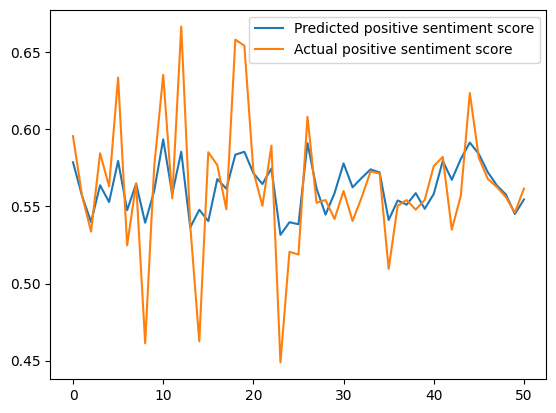

In [27]:
y_test = y_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
plt.plot(y_pred_on_train, label='Predicted positive sentiment score')
plt.plot(y_train, label='Actual positive sentiment score')
plt.legend()


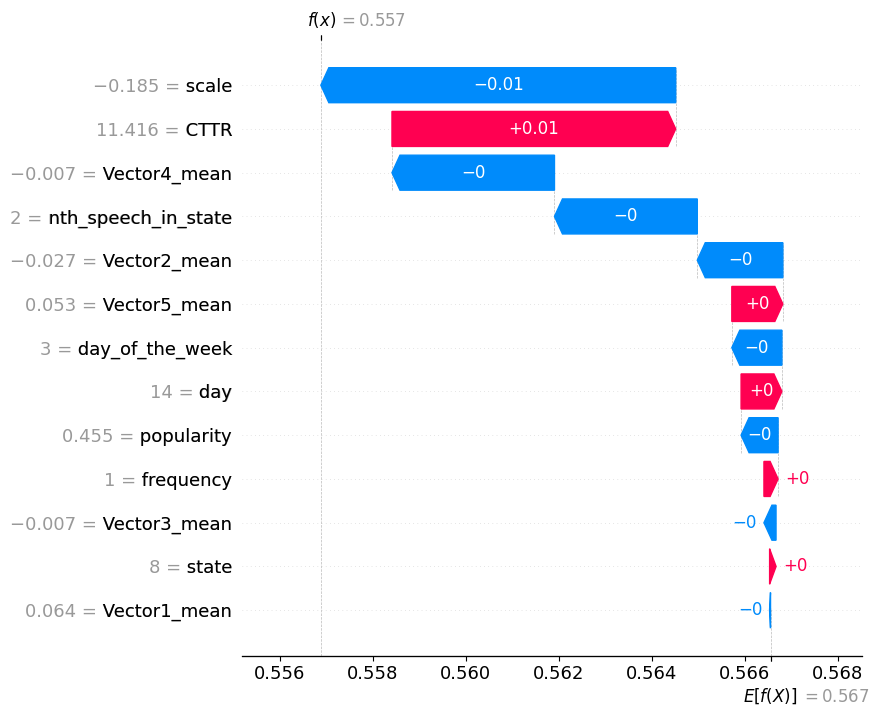

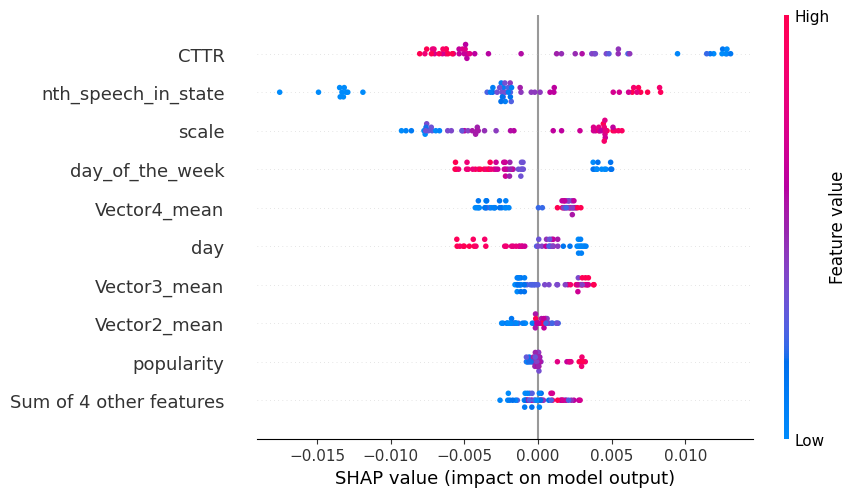

In [28]:
X10 = shap.utils.sample(X_train, 10)
explainer = shap.Explainer(rf_model.predict, X10)

shap_values = explainer(X_train)
shap.plots.waterfall(shap_values[1], max_display=14)

shap.plots.beeswarm(shap_values)

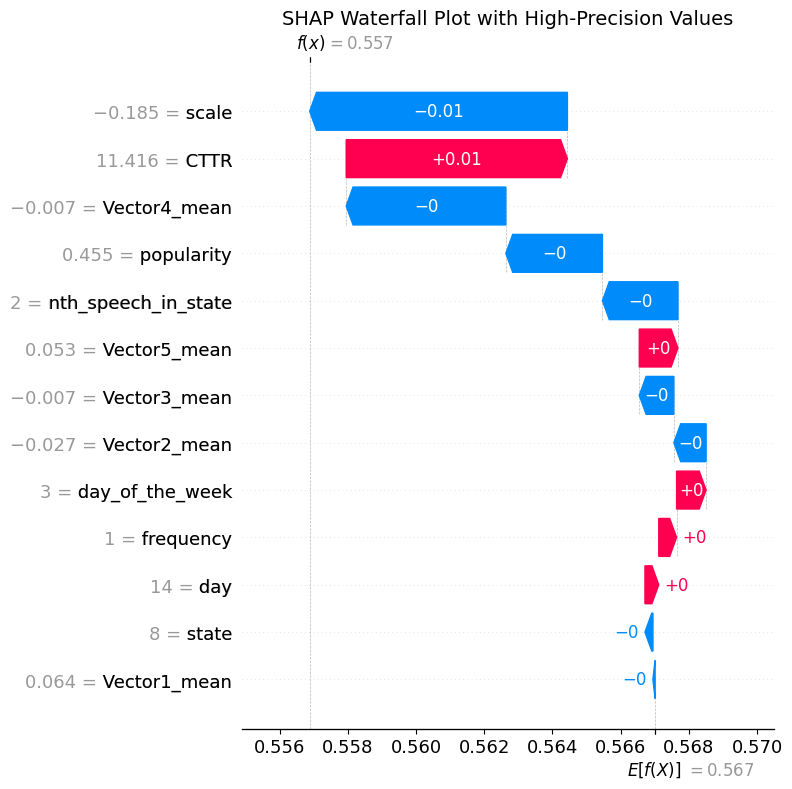

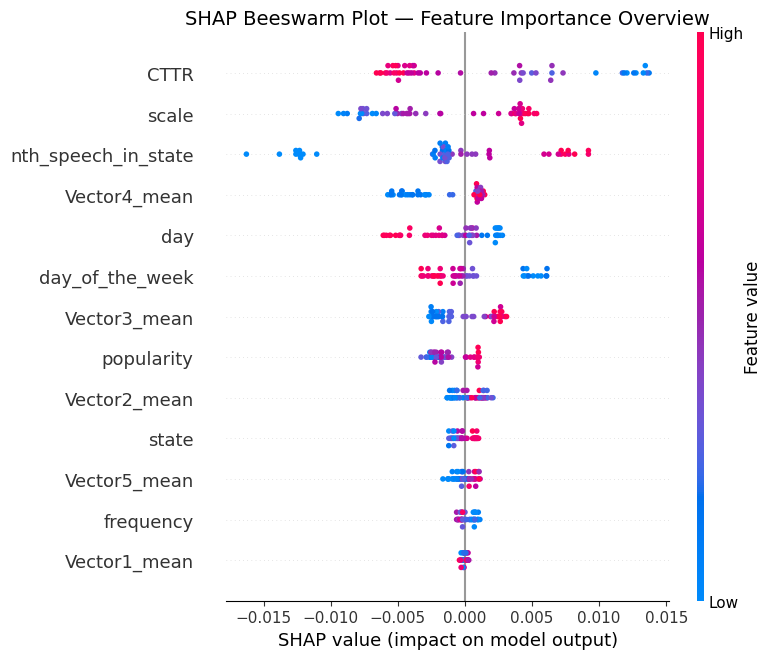

In [32]:
shap.plots.text_auto_precision = 4
X10 = shap.utils.sample(X_train, 10)
explainer = shap.Explainer(rf_model.predict, X10)
shap_values = explainer(X_train)

# Set precision (e.g., 4 digits after decimal)
np.set_printoptions(precision=4, suppress=True)

# Sample explainer and compute SHAP values
X10 = shap.utils.sample(X_train, 10, random_state=42)
explainer = shap.Explainer(rf_model.predict, X10)
shap_values = explainer(X_train)

# Waterfall plot (with high precision display in hover text)
plt.figure(figsize=(10, 6))
shap.plots.waterfall(shap_values[1], max_display=14, show=False)
plt.title("SHAP Waterfall Plot with High-Precision Values", fontsize=14)
plt.tight_layout()
plt.show()

# 🐝 Beeswarm plot for feature importance
plt.figure(figsize=(12, 6))
shap.plots.beeswarm(shap_values, max_display=14, show=False)
plt.title("SHAP Beeswarm Plot — Feature Importance Overview", fontsize=14)
plt.tight_layout()
plt.show()

In [48]:
pred = rf_model.predict(X_train.head(1))
pred

array([0.5786])

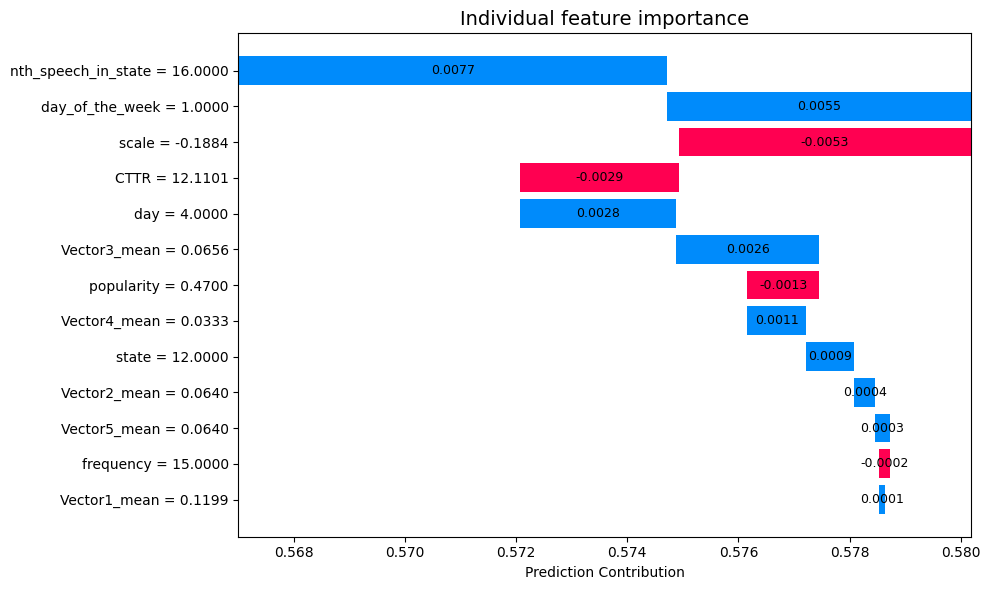

SHAP values explain this instance:
day                     4.000000
day_of_the_week         1.000000
state                  12.000000
nth_speech_in_state    16.000000
CTTR                   12.110096
scale                  -0.188384
popularity              0.470000
frequency              15.000000
Vector1_mean            0.119895
Vector2_mean            0.063951
Vector3_mean            0.065619
Vector4_mean            0.033294
Vector5_mean            0.063951
dtype: float64


In [55]:
# Official SHAP colors
shap_blue = "#008bfb" # #0080FF
shap_red = "#ff0051" 
# Choose a specific instance
shap_val = shap_values[0]
base_value = shap_val.base_values
contribs = shap_val.values
feature_names = shap_val.feature_names
feature_vals = shap_val.data

# Create DataFrame
df = pd.DataFrame({
    'Feature': feature_names,
    'SHAP': contribs,
    'Value': feature_vals
})

# Sort by absolute SHAP value
df = df.reindex(df['SHAP'].abs().sort_values(ascending=False).index)
df = df.head(14).reset_index(drop=True)

# Assign colors based on SHAP value sign (positive=blue, negative=red)
colors = [shap_blue if val > 0 else shap_red for val in df['SHAP']]

# Calculate left edge for bars
cumulative = base_value + df['SHAP'].cumsum() - df['SHAP']

# Plot
plt.figure(figsize=(10, 6))
for i, row in df.iterrows():
    plt.barh(i, row['SHAP'], left=cumulative[i], color=colors[i])
    label = f"{row['SHAP']:.4f}"
    plt.text(cumulative[i] + row['SHAP'] / 2, i, label,
             va='center', ha='center', fontsize=9, color='black')

# Y-axis labels
plt.yticks(
    ticks=range(len(df)),
    labels=[f"{f} = {v:.4f}" for f, v in zip(df['Feature'], df['Value'])]
)

plt.title("Individual feature importance", fontsize=14)
plt.xlabel("Prediction Contribution")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

print("SHAP values explain this instance:")
print(pd.Series(feature_vals, index=feature_names))

In [160]:
df_for_model.columns

Index(['doc_id', 'date', 'month', 'day', 'day_of_the_week', 'state',
       'nth_speech_in_state', 'negative', 'positive', 'neg_positive',
       'neg_negative', 'CTTR', 'scale', 'popularity', 'popularity_tminus1',
       'popularity_tplus1', 'tfidf1', 'tfidf2', 'tfidf3', 'tfidf4', 'tfidf5',
       'frequency'],
      dtype='object')

In [ ]:
#build model for predicting popularity
y = "popularity_tminus1"
y_data = df_for_model_final[y]
X_data = df_for_model_final[["day", "state", "nth_speech_in_state", "CTTR", 
                             "scale", "positive", "frequency", "Vector1_mean", "Vector2_mean", "Vector3_mean", 
                             "Vector4_mean", "Vector5_mean"]]
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.3, random_state=2024)

rf_model = RandomForestRegressor(n_estimators=100, random_state=2024, max_depth=5, min_samples_leaf=6)
rf_model.fit(X_train, y_train)

#predicting 
y_pred = rf_model.predict(X_test)
y_pred_on_train = rf_model.predict(X_train)
mse = mean_squared_error(y_test, y_pred)
mse2 = mean_squared_error(y_train, y_pred_on_train)
r2 = r2_score(y_test, y_pred)
r2_for_train = r2_score(y_train, y_pred_on_train)
print(mse, mse2, r2, r2_for_train)

0.0001104080138831223 7.105289100278799e-05 0.31497364622909574 0.6999620865261745


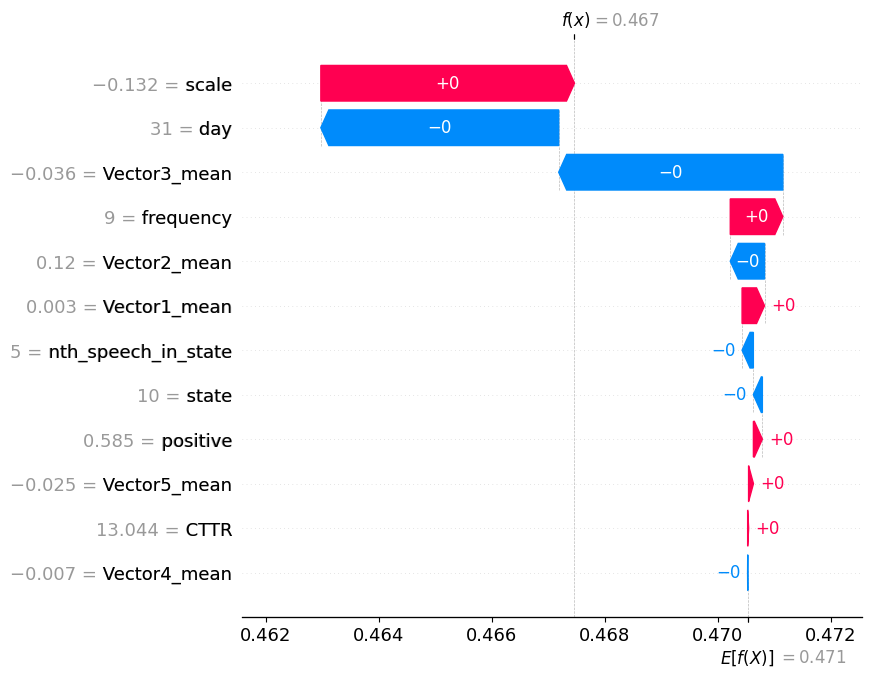

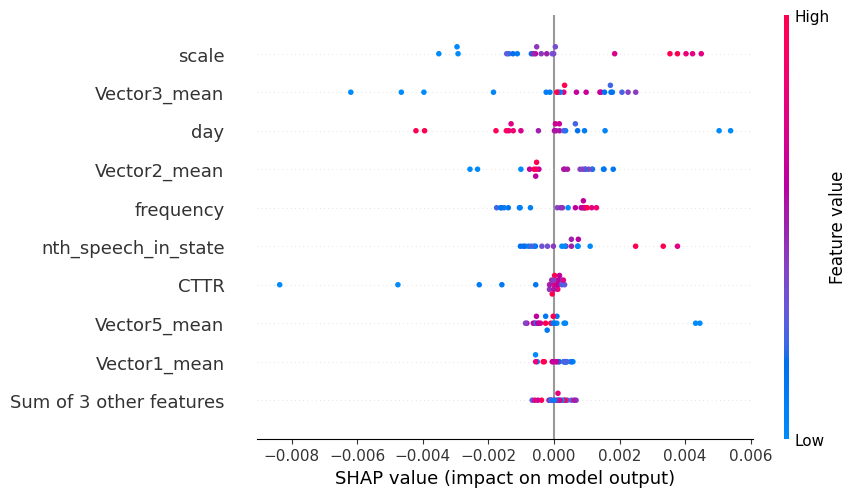

In [11]:
X10 = shap.utils.sample(X_test, 10)
explainer = shap.Explainer(rf_model.predict, X10)

shap_values = explainer(X_test)
shap.plots.waterfall(shap_values[2], max_display=14)

shap.plots.beeswarm(shap_values)

In [15]:
#build model for predicting CTTR
y = "CTTR"
y_data = df_for_model_final[y]
X_data = df_for_model_final[["day", "day_of_the_week", "state", "nth_speech_in_state", "scale", 
                             "popularity", "positive", "frequency", "Vector1_mean", "Vector2_mean", "Vector3_mean", 
                             "Vector4_mean", "Vector5_mean"]]
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.3, random_state=2024)

rf_model = RandomForestRegressor(n_estimators=100, random_state=2024)
rf_model.fit(X_train, y_train)

#predicting 
y_pred = rf_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(mse, r2)

0.45714266490613525 -0.005702306450539929


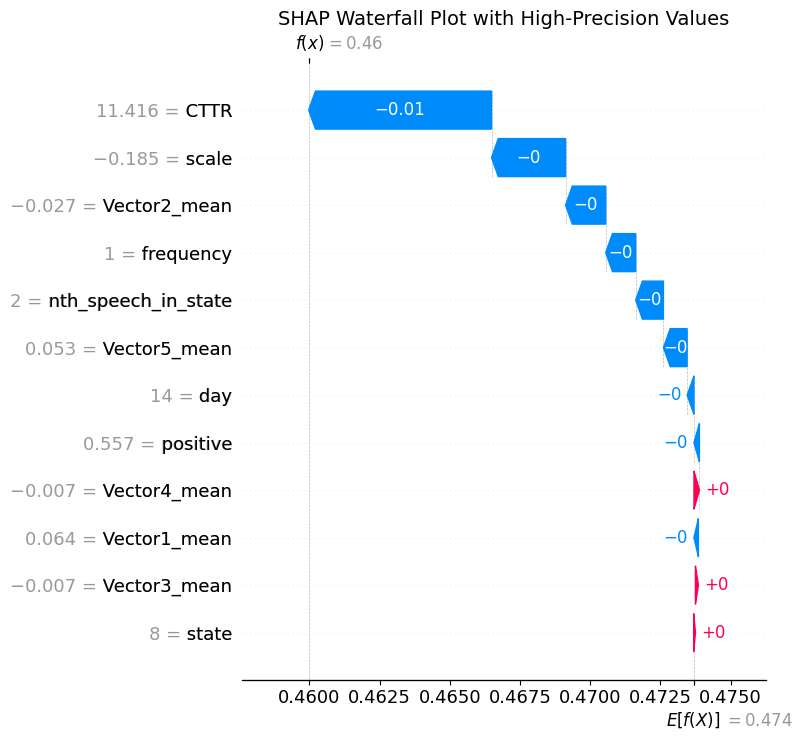

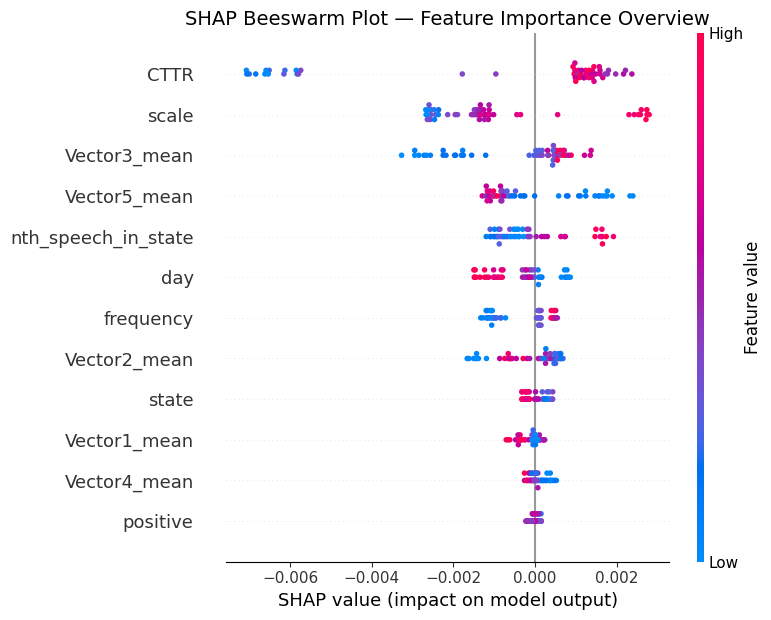

In [62]:
shap.plots.text_auto_precision = 4
X10 = shap.utils.sample(X_train, 10)
explainer = shap.Explainer(rf_model.predict, X10)
shap_values = explainer(X_train)

# Set precision (e.g., 4 digits after decimal)
np.set_printoptions(precision=4, suppress=True)

# Sample explainer and compute SHAP values
X10 = shap.utils.sample(X_train, 10, random_state=42)
explainer = shap.Explainer(rf_model.predict, X10)
shap_values = explainer(X_train)

# Waterfall plot (with high precision display in hover text)
plt.figure(figsize=(10, 6))
shap.plots.waterfall(shap_values[1], max_display=14, show=False)
plt.title("SHAP Waterfall Plot with High-Precision Values", fontsize=14)
plt.tight_layout()
plt.show()

# 🐝 Beeswarm plot for feature importance
plt.figure(figsize=(12, 6))
shap.plots.beeswarm(shap_values, max_display=14, show=False)
plt.title("SHAP Beeswarm Plot — Feature Importance Overview", fontsize=14)
plt.tight_layout()
plt.show()